In [1]:
import os
from pathlib import Path

# Configure paths (adjust as needed)
XML_DIR = Path("xml_files")
MODEL_DIR = Path("RoBERTa_prem_conc_finetuned")
OUTPUT_DIR = Path("graph_data")

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify XML files exist
if not XML_DIR.exists():
    raise FileNotFoundError(f"XML directory not found: {XML_DIR}")
xml_files = [f for f in XML_DIR.glob("*.xml") if f.is_file()]
print(f"Found {len(xml_files)} XML files")


Found 22 XML files


In [2]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModel.from_pretrained(MODEL_DIR)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)


/home/suyamoon/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/suyamoon/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-04-11 18:21:02.269022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 18:21:02.280133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT fac

cuda


In [3]:
import xml.etree.ElementTree as ET

def process_xml(xml_path):
    """Process XML with guaranteed edge validation"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Phase 1: Collect all valid nodes
        nodes = []
        id_registry = set()
        for elem in root.iter():
            if elem.tag not in ('prem', 'conc'):
                continue
                
            node_id = elem.attrib.get('ID', '').strip()
            if not node_id or node_id in id_registry:
                continue
                
            nodes.append({
                'id': node_id,
                'text': elem.text.strip() if elem.text else '',
                'type': elem.tag,
                'xml_file': xml_path.name
            })
            id_registry.add(node_id)
            
        # Create ID to index mapping
        id_to_idx = {node['id']: idx for idx, node in enumerate(nodes)}
        
        # Phase 2: Process edges with strict validation
        edges = {'support': [], 'attack': []}
        for elem in root.iter():
            if elem.tag not in ('prem', 'conc'):
                continue
                
            source_id = elem.attrib.get('ID', '').strip()
            if not source_id or source_id not in id_to_idx:
                continue

            # Process relationships with rigorous cleaning
            def clean_split(value):
                return [t.strip() for t in value.strip().split('|') if t.strip()]
                
            for rel_type in ['SUP', 'ATT']:
                if rel_type in elem.attrib:
                    targets = clean_split(elem.attrib[rel_type])
                    edge_key = 'support' if rel_type == 'SUP' else 'attack'
                    
                    for target_id in targets:
                        if target_id in id_to_idx:
                            edges[edge_key].append((
                                source_id, 
                                target_id,
                                id_to_idx[source_id],
                                id_to_idx[target_id]
                            ))
                            print(f"Added {edge_key} edge: {source_id} → {target_id}")
                        else:
                            print(f"Ignoring invalid target: {target_id} for {source_id}")
        
        return nodes, edges, id_to_idx
        
    except ET.ParseError as e:
        print(f"XML parse error in {xml_path.name}: {e}")
        return [], {'support': [], 'attack': []}, {}


In [4]:
from tqdm import tqdm

def generate_embeddings(texts, batch_size=4):
    """Generate embeddings in batches"""
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch, 
            padding=True, 
            truncation=True, 
            max_length=512, 
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        embeddings.append(outputs.last_hidden_state[:,0,:].cpu())
    
    return torch.cat(embeddings, dim=0)


In [ ]:
import random
def add_negative_samples(nodes, edges, id_map, negative_ratio=0.1):
    """Generate 'No Relation' edges based on existing support/attack edges"""
    # Get all existing edges as tuples
    existing_edges = set()
    for edge_type in edges.values():
        for edge in edge_type:
            src, tgt = edge[:2]
            existing_edges.add((id_map[src], id_map[tgt]))
    
    # Potential edges (all possible node pairs)
    node_indices = list(range(len(nodes)))
    potential_edges = []
    
    # Generate all possible directed edges
    for src in node_indices:
        for tgt in node_indices:
            if src != tgt and (src, tgt) not in existing_edges:
                potential_edges.append((src, tgt))
    
    # Sample negative edges (adjust ratio based on dataset size)
    total_existing = len(existing_edges)
    num_negative = int(total_existing * negative_ratio)
    
    # Randomly sample from potential edges
    if potential_edges and num_negative > 0:
        negative_samples = random.sample(
            potential_edges, 
            min(num_negative, len(potential_edges))
        )
        return negative_samples
    return []


In [ ]:
import torch
from torch_geometric.data import Data

all_data = []

for xml_file in tqdm(xml_files, desc="Processing XML files"):
    # 1. Parse XML
    print("------------------------------------------------------------------- processing ", xml_file)
    nodes, edges, id_map = process_xml(xml_file)
    
    # 2. Generate embeddings
    texts = [node["text"] for node in nodes]
    embeddings = generate_embeddings(texts)
    
    # 3. Create node features (embedding + type)
    type_features = torch.zeros((len(nodes), 2))
    for i, node in enumerate(nodes):
        type_features[i, 0 if node["type"] == "prem" else 1] = 1
    
    node_features = torch.cat([embeddings, type_features], dim=1)
    
    # 4. Create edge indices
    edge_indices = []
    edge_types = []
    
    for rel_type, rel_edges in edges.items():
        for edge in rel_edges:  # Changed from (src, tgt)
            src_id, tgt_id = edge[:2]  # Extract first two elements
            if src_id in id_map and tgt_id in id_map:
                edge_indices.append([id_map[src_id], id_map[tgt_id]])
                edge_types.append(0 if rel_type == "support" else 1)

    # negative_edges = add_negative_samples(nodes, edges, id_map)
    # for src, tgt in negative_edges:
    #     edge_indices.append([src, tgt])
    #     edge_types.append(2)  # No relation class


    # 5. Create PyG Data object
    edge_index = torch.tensor(edge_indices).t().contiguous()
    edge_type = torch.tensor(edge_types)
    
    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_type=edge_type,
        xml_file=xml_file.name
    )
    
    # 6. Save per-document graph
    output_path = OUTPUT_DIR / f"{xml_file.stem}.pt"
    torch.save(data, output_path)
    
    all_data.append(data)

print(f"Processed {len(all_data)} legal documents")


Processing XML files:   0%|          | 0/22 [00:00<?, ?it/s]

------------------------------------------------------------------- processing  xml_files/A2018_Commission v Spain.xml
Added support edge: A5 → A1
Added support edge: A5 → A2
Added support edge: A5 → A3
Added support edge: A5 → A4
Ignoring invalid target: Rule for A8
Added support edge: A12 → A11
Added support edge: A19 → A17
Added support edge: A19 → A18
Added support edge: A22 → A19
Added support edge: A22 → A21
Added attack edge: A22 → A23
Added support edge: A24 → A8
Added support edge: A24 → A9
Added support edge: A24 → A9bis
Added support edge: A27 → A25
Added support edge: A27 → A26
Added support edge: A28 → A27
Added support edge: A31 → A29
Added support edge: A31 → A30
Added support edge: A32 → A10
Added support edge: A32 → A10bis
Added support edge: A32 → A10ter
Added support edge: A32 → A10quater
Added support edge: A32 → A10quinquies
Added support edge: A32 → A11
Added support edge: A32 → A12
Added support edge: A32 → A13
Added support edge: A32 → A14
Added support edge: A3

Processing XML files:   5%|▍         | 1/22 [00:01<00:21,  1.02s/it]

------------------------------------------------------------------- processing  xml_files/R2017_European Commission v Frucona Košice a.xml
Added support edge: A2 → A1
Added support edge: A6 → A7
Added support edge: A8 → A1
Added support edge: A8 → A2
Added support edge: A8 → A3
Added support edge: A8 → A4
Added support edge: A8 → A5
Added support edge: A8 → A6
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A15 → A10
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: B2 → B1
Added support edge: B6 → B2
Added support edge: B6 → B3
Added support edge: B6 → B4
Added support edge: B6 → B5
Added support edge: C2 → C1
Added support edge: D3 → D2
Added support edge: D10 → D11
Added support edge: D10 → D12
Added support edge: D10 → D13
Added support edge: D10 → D14
Added support edge: D10 → D15
Added support edge: D16 → D11
Added support edge: D16 → D12
Added support edge: D16 → D13
Added support edge: D16 → D14
Added support edge: D16 

Processing XML files:   9%|▉         | 2/22 [00:01<00:13,  1.49it/s]

------------------------------------------------------------------- processing  xml_files/A2018_Dirk Andres v European Commission.xml
Added support edge: A3 → A1
Added attack edge: A3 → A4
Added attack edge: A4 → A12
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A10 → A9
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A10
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: A16 → A5
Added support edge: A16 → A3
Added support edge: A16 → A15
Added support edge: A17 → A5
Added support edge: A17 → A3
Added support edge: A17 → A15
Added support edge: A20 → A16
Added support edge: A20 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added attack edge: B1 → B1
Added support edge: B5 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B5bis
Added support edge: B7 → B6
Added support edge: B8 → B7
Added support edge: C8 → C1


Processing XML files:  14%|█▎        | 3/22 [00:02<00:13,  1.46it/s]

------------------------------------------------------------------- processing  xml_files/A2017_European Commission v Italian Republic_DT.xml
Added support edge: A9 → A3
Added support edge: A9 → A4
Added support edge: A9 → A5
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A11 → A1
Added support edge: A11 → A2
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A12 → A11
Added support edge: B7 → B2
Added support edge: B7 → B3
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added attack edge: B7 → B26
Added support edge: B9 → B1
Added support edge: B9 → B7
Added support edge: B14 → B12
Added support edge: B14 → B13
Added support edge: B15 → B12
Added support edge: B15 → B13
Added support edge: B18 → B1
Added support edge: B18 → B9
Added support edge: B18 → B10
Added support edge: B18 → B11
Added support edge: B18 → B14
Added support edge: B18 → B15
Added support edge: B

Processing XML files:  18%|█▊        | 4/22 [00:02<00:10,  1.74it/s]

------------------------------------------------------------------- processing  xml_files/R2021_FVE Holýšov I and Others v Commission.xml
Added support edge: A1 → A2
Added support edge: A4 → A1
Added support edge: B5 → B1
Added support edge: B5 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B6 → B5
Added support edge: C4 → C3
Added support edge: C5 → C1
Added support edge: C5 → C2
Added support edge: C5 → C4
Added support edge: C6 → C7
Added support edge: C10 → C11
Added support edge: C12 → C5
Added support edge: C12 → C6
Added support edge: C12 → C7
Added support edge: C12 → C9
Added attack edge: D1 → D2
Added support edge: D2 → D3
Added support edge: D2 → D3bis
Added support edge: D2 → D4
Added support edge: D4 → D2
Added attack edge: D5 → D6
Added attack edge: D5 → D7
Added support edge: D8 → D6
Added support edge: D8 → D7
Added attack edge: D9 → D10
Added support edge: D12 → D4
Added support edge: D12 → D8
Added support edge: D12 → D11
Added attack

Processing XML files:  23%|██▎       | 5/22 [00:02<00:08,  2.04it/s]

------------------------------------------------------------------- processing  xml_files/R2016_European Commission v Hansestadt Lübeck.xml
Added support edge: A6 → A5
Added support edge: A7 → A1
Added support edge: A7 → A2
Added support edge: A7 → A3
Added support edge: A7 → A4
Added support edge: A7 → A6
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: B3 → B2
Added support edge: B11 → B8
Added support edge: B11 → B9
Added support edge: B11 → B10
Added support edge: B13 → B1
Added support edge: B13 → B3
Added support edge: B13 → B4
Added support edge: B13 → B5
Added support edge: B13 → B6
Added support edge: B13 → B7
Added support edge: B13 → B11
Added support edge: B13 → B12
Added support edge: B14 → B13
Added support edge: C8 → C1
Added support edge: C8 → C1bis
Added support edge: C8 → C1ter
Added support edge: C8 → C1quater
Added support edge: C8 → C1quinquies
Added support edge: C8 → C2
Added support edge: C8 → C3
Added support edge: C8 → C4
Added sup

Processing XML files:  27%|██▋       | 6/22 [00:03<00:08,  1.88it/s]

------------------------------------------------------------------- processing  xml_files/R2017__Viasat Broadcasting UK Ltd v European Commission.xml
Added support edge: A6 → A2
Added support edge: A6 → A3
Added support edge: A6 → A4
Added support edge: A6 → A5
Added support edge: A7 → A1
Added support edge: A7 → A1bis
Added support edge: A7 → A6
Added support edge: A8 → A7
Added support edge: B1 → B12
Added attack edge: B1 → B18
Added support edge: B7 → B2
Added support edge: B7 → B2bis
Added support edge: B7 → B2ter
Added support edge: B7 → B3
Added support edge: B7 → B3bis
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B7 → B6a
Added support edge: B7 → B6b
Added support edge: B7 → B6c
Added support edge: B7 → B6d
Added attack edge: B12 → B13
Added support edge: B13 → B7
Added support edge: B13 → B8
Added support edge: B13 → B9
Added support edge: B13 → B10
Added support edge: B13 → B10a
Added support edge: B13 → B11
Added supp

Processing XML files:  32%|███▏      | 7/22 [00:03<00:07,  2.10it/s]

------------------------------------------------------------------- processing  xml_files/R2006_European Commission v Italian Republic.xml
Added attack edge: A2 → A5
Added support edge: A5 → A3
Added support edge: A5 → A4
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A11 → A1
Added support edge: A11 → A5
Added support edge: A11 → A10
Added support edge: B10 → B16
Added support edge: B13 → B1
Added support edge: B13 → B2
Added support edge: B13 → B3
Added support edge: B13 → B4
Added support edge: B13 → B5
Added support edge: B13 → B14
Added support edge: B13 → B15
Added support edge: B16 → B17
Added support edge: B16 → B22
Added support edge: B16 → B23
Added support edge: B17 → B13
Added support edge: B17 → B11
Added support edge: B17 → B12
Added support edge: B17 → B6
Added support edge: B17 → B7
Added support edge: B17 → B18
Added support edge: B17 → B19
Added support edge: B17 → B8
Added support e

Processing XML files:  36%|███▋      | 8/22 [00:04<00:05,  2.42it/s]

------------------------------------------------------------------- processing  xml_files/R2016_Netherlands Maritime Technology Association formerly Scheepsbouw Nederland v European Commission.xml
Added attack edge: A1 → A2
Added attack edge: A2 → A6
Added support edge: A6 → A3
Added support edge: A6 → A4
Added support edge: A6 → A5
Added support edge: A8 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added attack edge: A16 → A20
Added support edge: A20 → A17
Added support edge: A20 → A18
Added support edge: A20 → A19
Added attack edge: A22 → A22
Added support edge: A24 → A20
Added support edge: A24 → A21
Added support edge: A24 → A23
Added support edge: A25 → A10
Added support edge: A25 → A15
Added support edge: A25 → A24
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: B4 → B3
Added support edge: B8 → B4
Added support edge: B8 → B5
Added support edge: B8 → B6
Added support edge: B8 → B7
Added attack edge: C2 → C8
Added support edge: C4 → C3


Processing XML files:  41%|████      | 9/22 [00:04<00:05,  2.38it/s]

------------------------------------------------------------------- processing  xml_files/R2016_Orange v European Commission.xml
Added attack edge: A2 → A24
Added attack edge: A2 → A25
Added attack edge: A2 → A27
Added support edge: A6 → A5
Added support edge: A6 → A7
Added support edge: A6 → A8
Added support edge: A6 → A10
Added support edge: A10 → A9
Added support edge: A11 → A5
Added support edge: A11 → A7
Added support edge: A11 → A8
Added support edge: A11 → A10
Added support edge: A12 → A6
Added support edge: A12 → A11
Added support edge: A15 → A13
Added support edge: A15 → A14
Added support edge: A18 → A17
Added support edge: A19 → A15
Added support edge: A19 → A16
Added support edge: A19 → A18
Added support edge: A21 → A19
Added support edge: A21 → A20
Added attack edge: A22 → A24
Added attack edge: A22 → A25
Added attack edge: A22 → A27
Added attack edge: A23 → A24
Added attack edge: A23 → A25
Added attack edge: A23 → A27
Added support edge: A26 → A24
Added support edge: A26 →

Processing XML files:  45%|████▌     | 10/22 [00:05<00:05,  2.26it/s]

------------------------------------------------------------------- processing  xml_files/R2021_World Duty Free v. Commission.xml
Added support edge: A2 → A1
Added support edge: A3 → A2
Added support edge: A6 → A5
Added support edge: A8 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: B2 → B1
Added support edge: B3 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B14 → B7
Added support edge: B14 → B8
Added support edge: B14 → B9
Added support edge: B14 → B10
Added support edge: B14 → B11
Added support edge: B14 → B12
Added support edge: B14 → B13
Added attack edge: B15 → B34
Added attack edge: B15 → B40
Added attack edge: B15 → B39
Added attack edge: B15 → B62
Added attack edge: B15 → B71
Added support edge: B16bis → B16ter
Added support edge: B16bis → B16quater
Added attack edge: B16bis → B33
Added support edge: B19 → B17
Added support edge: B19 → B18
Added support e

Processing XML files:  50%|█████     | 11/22 [00:06<00:07,  1.53it/s]

------------------------------------------------------------------- processing  xml_files/R2013_Telefónica SA v European Commission.xml
Added support edge: A9 → A8
Added attack edge: A12 → A18
Added support edge: A17 → A1
Added support edge: A17 → A2
Added support edge: A17 → A3
Added support edge: A17 → A4
Added support edge: A17 → A5
Added support edge: A17 → A6
Added support edge: A17 → A7
Added support edge: A17 → A9
Added support edge: A17 → A10
Added support edge: A17 → A11
Added support edge: A17 → A13
Added support edge: A17 → A14
Added support edge: A17 → A15
Added support edge: A17 → A16
Added support edge: A19 → A17
Added support edge: A19 → A18
Added support edge: A20 → A19
Added support edge: B6bis → B1
Added support edge: B6bis → B2
Added support edge: B6bis → B3
Added support edge: B6bis → B4
Added support edge: B6bis → B5
Added support edge: B6bis → B6
Added support edge: B9 → B6
Added support edge: B9 → B7
Added support edge: B9 → B8
Added support edge: B10 → B9
Added 

Processing XML files:  55%|█████▍    | 12/22 [00:06<00:05,  1.88it/s]

------------------------------------------------------------------- processing  xml_files/R2004_Italian Republic v Commission of the European Communities.xml
Added support edge: A5 → A2
Added support edge: A5 → A3
Added support edge: A5 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: A8 → A9
Added support edge: A8 → A10
Added support edge: A11 → A5
Added support edge: A11 → A5bis
Added support edge: A11 → A8
Added support edge: A12 → A11
Added support edge: B4 → B3
Added support edge: B9 → B5
Added support edge: B9 → B6
Added support edge: B9 → B7
Added support edge: B9 → B8
Added support edge: B12 → B1
Added support edge: B12 → B2
Added support edge: B12 → B4
Added support edge: B12 → B9
Added support edge: B12 → B10
Added support edge: B12 → B11
Added support edge: B13 → B12
Added support edge: C5 → C3
Added support edge: C5 → C4
Added support edge: C7 → C9
Added support edge: C9 → C8
Added support edge: C13 → C12
Added support edge: C14 → C13
Added s

Processing XML files:  59%|█████▉    | 13/22 [00:07<00:04,  1.84it/s]

------------------------------------------------------------------- processing  xml_files/R2002_associação dos refinadores de açúcar portugueses.xml
Added attack edge: A1 → A7
Added support edge: A3 → A2
Added support edge: A5 → A4
Added support edge: A7 → A5
Added support edge: A7 → A6bis
Added support edge: B1 → B2
Added support edge: B1 → B5
Added support edge: B4 → B3
Added support edge: B5 → B4
Added support edge: B6 → B5
Added support edge: B8 → B13
Added support edge: B10 → B9
Added support edge: B11 → B10
Added support edge: B12 → B11
Added support edge: B13 → B12
Added support edge: B14 → B8
Added support edge: B16 → B15
Added support edge: B17 → B6
Added support edge: B17 → B14
Added support edge: B17 → B16
Added support edge: C8 → C7
Added support edge: C9 → C2
Added support edge: C9 → C2bis
Added support edge: C9 → C3
Added support edge: C9 → C4
Added support edge: C9 → C5
Added support edge: C9 → C8
Added support edge: C10 → C9
Added support edge: C11 → C1
Added support ed

Processing XML files:  64%|██████▎   | 14/22 [00:07<00:04,  1.76it/s]

------------------------------------------------------------------- processing  xml_files/A2009_Commission of the European Communities v Koninklijke FrieslandCampina NV_M.xml
Added support edge: A2 → A1
Added support edge: A4 → A2
Added support edge: A4 → A3
Added support edge: A5 → A1
Added support edge: A6 → A7
Added support edge: A6 → A7bis
Added support edge: A6 → A8
Added support edge: A7 → A5
Added support edge: A7bis → A5
Added support edge: A8 → A5
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A14 → A11
Added support edge: A14 → A12
Added support edge: A14 → A13
Added support edge: A15 → A6
Added support edge: A15 → A14
Added support edge: A18 → A4
Added support edge: A18 → A14
Added support edge: A19 → A18
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: B4 → B3
Added support edge: B5 → B4
Added support edge: B6 → B7
Added support edge: B8 → B6
Added support edge: B9 → B5
Added support edge: B10 → B9
Added support edg

Processing XML files:  68%|██████▊   | 15/22 [00:08<00:03,  1.95it/s]

------------------------------------------------------------------- processing  xml_files/A2011_European Commission (C-106_09 P) and Kingdom of Spain (C-107_09 P) v Government of Gibraltar and United Kingdom of Great Britain and Northern Ireland.xml
Added support edge: A1 → A2
Added support edge: A3 → A5
Added support edge: A8 → A7
Added support edge: A10 → A8
Added support edge: A10 → A9
Added support edge: A14 → A15
Added support edge: A14 → A16
Added support edge: A14 → A17
Added support edge: A14 → A19
Added support edge: A14 → A20
Added support edge: A18 → A15
Added support edge: A18 → A16
Added support edge: A18 → A17
Added support edge: A18 → A19
Added support edge: A18 → A20
Added support edge: A21 → A1
Added support edge: A21 → A3
Added support edge: A21 → A13
Added support edge: A21 → A14
Added support edge: A21 → A18
Added support edge: B1 → B2
Added attack edge: B1 → B3
Added attack edge: B1 → B28
Added support edge: B3 → B6
Added support edge: B3 → B7
Added support edge: B

Processing XML files:  73%|███████▎  | 16/22 [00:08<00:02,  2.14it/s]

------------------------------------------------------------------- processing  xml_files/A2017__European Commission v Italian Republic_DT.xml
Added support edge: A9 → A3
Added support edge: A9 → A4
Added support edge: A9 → A5
Added support edge: A9 → A6
Added support edge: A9 → A7
Added support edge: A9 → A8
Added support edge: A11 → A1
Added support edge: A11 → A2
Added support edge: A11 → A9
Added support edge: A11 → A10
Added support edge: A12 → A11
Added support edge: B7 → B2
Added support edge: B7 → B3
Added support edge: B7 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added attack edge: B7 → B26
Added support edge: B9 → B1
Added support edge: B9 → B7
Added support edge: B14 → B12
Added support edge: B14 → B13
Added support edge: B15 → B12
Added support edge: B15 → B13
Added support edge: B18 → B1
Added support edge: B18 → B9
Added support edge: B18 → B10
Added support edge: B18 → B11
Added support edge: B18 → B14
Added support edge: B18 → B15
Added support edge: 

Processing XML files:  77%|███████▋  | 17/22 [00:08<00:02,  2.22it/s]

------------------------------------------------------------------- processing  xml_files/R2013_3F, formerly Specialarbejderforbundet i Danmark (SID) v European Commission.xml
Added support edge: A8 → A7
Added support edge: A9 → A4
Added support edge: A9 → A8
Added support edge: A9 → A8bis
Added support edge: A12 → A10
Added support edge: A12 → A11
Added attack edge: A13 → A18
Added support edge: A17 → A16
Added support edge: A18 → A1
Added support edge: A18 → A2
Added support edge: A18 → A3
Added support edge: A18 → A3bis
Added support edge: A18 → A4
Added support edge: A18 → A5
Added support edge: A18 → A6
Added support edge: A18 → A9
Added support edge: A18 → A12
Added support edge: A18 → A14
Added support edge: A18 → A15
Added support edge: A18 → A17
Added support edge: B2 → B3
Added support edge: B2 → B4
Added support edge: B5 → B2
Added attack edge: B10 → B13
Added support edge: B14 → B8
Added support edge: B14 → B9
Added support edge: B14 → B11
Added support edge: B14 → B12
Adde

Processing XML files:  82%|████████▏ | 18/22 [00:09<00:01,  2.24it/s]

------------------------------------------------------------------- processing  xml_files/R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml
Added support edge: A2 → A1
Added support edge: A3 → A2
Added support edge: A6 → A5
Added support edge: A8 → A4
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: B2 → B1
Added support edge: B3 → B2
Added support edge: B5 → B3
Added support edge: B5 → B4
Added support edge: B7 → B5
Added support edge: B7 → B6
Added support edge: B14 → B7
Added support edge: B14 → B8
Added support edge: B14 → B9
Added support edge: B14 → B10
Added support edge: B14 → B11
Added support edge: B14 → B12
Added support edge: B14 → B13
Added attack edge: B15 → B34
Added attack edge: B15 → B40
Added attack edge: B15 → B39
Added attack edge: B15 → B62
Added attack edge: B15 → B71
Added support edge: B16bis → B16ter
Added support edge: B16bis → B16quater
Added attack edge: B16bis → B33
Added support edge: B19 → B

Processing XML files:  86%|████████▋ | 19/22 [00:10<00:01,  1.56it/s]

------------------------------------------------------------------- processing  xml_files/A2012__BNP Paribas and Banca Nazionale del Lavoro SpA (BNL) v European Commission.xml
Added support edge: A4 → A1
Added support edge: A4 → A2
Added support edge: A4 → A3
Added support edge: A4 → A3bis
Added support edge: A8 → A6
Added support edge: A8 → A7
Added support edge: A12bis → A9
Added support edge: A12bis → A9bis
Added support edge: A12bis → A9ter
Added support edge: A12bis → A10
Added support edge: A12bis → A11
Added support edge: A12bis → A12
Added support edge: A13 → A9
Added support edge: A13 → A12
Added support edge: A17 → A14
Added support edge: A17 → A15
Added support edge: A17 → A16
Added support edge: A19 → A18
Added support edge: A21 → A20
Added attack edge: B1 → B2
Added attack edge: B1 → B3
Added support edge: B4 → B1
Added support edge: B4 → B2
Added support edge: C9 → C8
Added support edge: C10 → C9
Added support edge: C12 → C11
Added support edge: C14 → C12
Added support ed

Processing XML files:  91%|█████████ | 20/22 [00:10<00:01,  1.76it/s]

------------------------------------------------------------------- processing  xml_files/R2016_Hellenic Republic v European Commission.xml
Added support edge: A2 → A1
Added support edge: A8 → A7
Added support edge: A9 → A6
Added support edge: A9 → A8
Added support edge: A10 → A9
Added support edge: A11 → A10
Added support edge: A15 → A14
Added support edge: A16 → A11
Added support edge: A16 → A12
Added support edge: A16 → A13
Added support edge: A16 → A15
Added support edge: A20 → A18
Added support edge: A20 → A19
Added support edge: A21 → A18
Added support edge: A21 → A19
Added support edge: A22 → A2
Added support edge: A22 → A3
Added support edge: A22 → A4
Added support edge: A22 → A5
Added support edge: A22 → A16
Added support edge: A22 → A20
Added support edge: A22 → A21
Added support edge: A26 → A2
Added support edge: A26 → A3
Added support edge: A26 → A4
Added support edge: A26 → A23
Added support edge: A26 → A24
Added support edge: A26 → A25
Added support edge: A26 → A28
Added 

Processing XML files:  95%|█████████▌| 21/22 [00:11<00:00,  1.77it/s]

------------------------------------------------------------------- processing  xml_files/A2013_European Commission v Ireland and Others.xml
Added support edge: A3 → A1
Added support edge: A3 → A2
Added support edge: A7 → A4
Added support edge: A7 → A5
Added support edge: A7 → A6
Added support edge: A9 → A10
Added support edge: A11 → A12
Added support edge: A13 → A3
Added support edge: A13 → A7
Added support edge: A13 → A8
Added support edge: A13 → A9
Added support edge: A13 → A11
Added support edge: A15 → A14
Added support edge: A25 → A15
Added support edge: A25 → A16
Added support edge: A25 → A17
Added support edge: A25 → A18
Added support edge: A25 → A19
Added support edge: A25 → A20
Added support edge: A25 → A21
Added support edge: A25 → A22
Added support edge: A25 → A23
Added support edge: A25 → A24
Added support edge: A27 → A28
Added support edge: A27 → A29
Added support edge: A27 → A30
Added support edge: A27 → A34
Added support edge: A27 → A35
Added support edge: A32 → A31
Adde

Processing XML files: 100%|██████████| 22/22 [00:11<00:00,  1.88it/s]

Processed 22 legal documents


In [7]:
import torch
from pathlib import Path

def get_dataset_stats(output_dir="graph_data"):
    pt_files = list(Path(output_dir).glob("*.pt"))
    if not pt_files:
        return "No processed files found. Run XML processing first."

    total_stats = {
        'total_nodes': 0,
        'total_support': 0,
        'total_attack': 0,
        'files': []
    }

    for pt_file in pt_files:
        try:
            data = torch.load(pt_file, weights_only=False)
            support = (data.edge_type == 0).sum().item()
            attack = (data.edge_type == 1).sum().item()
            
            file_stats = {
                'filename': pt_file.name,
                'nodes': data.x.shape[0],
                'support': support,
                'attack': attack
            }
            
            total_stats['total_nodes'] += file_stats['nodes']
            total_stats['total_support'] += support
            total_stats['total_attack'] += attack
            total_stats['files'].append(file_stats)
            
        except Exception as e:
            print(f"Error loading {pt_file.name}: {str(e)}")
    
    return total_stats

# Get statistics
stats = get_dataset_stats()

# Display results
print(f"""
## Dataset Summary
- **Total Documents**: {len(stats['files'])}
- **Total Arguments**: {stats['total_nodes']}
- **Support Relationships**: {stats['total_support']}
- **Attack Relationships**: {stats['total_attack']}
- **Ratio (Support:Attack)**: {stats['total_support']}:{stats['total_attack']}
""")

# Optional: Per-file breakdown
print("\n## Per-File Breakdown")
for file in stats['files']:
    print(f"""
**{file['filename']}**
- Nodes: {file['nodes']}
- Support: {file['support']}
- Attack: {file['attack']}""")



## Dataset Summary
- **Total Documents**: 22
- **Total Arguments**: 1529
- **Support Relationships**: 1355
- **Attack Relationships**: 98
- **Ratio (Support:Attack)**: 1355:98


## Per-File Breakdown

**R2021_World Duty Free v. Commission.pt**
- Nodes: 147
- Support: 116
- Attack: 22

**R2013_Telefónica SA v European Commission.pt**
- Nodes: 37
- Support: 33
- Attack: 1

**A2018_Dirk Andres v European Commission.pt**
- Nodes: 74
- Support: 73
- Attack: 5

**A2012__BNP Paribas and Banca Nazionale del Lavoro SpA (BNL) v European Commission.pt**
- Nodes: 49
- Support: 28
- Attack: 4

**R2016_European Commission v Hansestadt Lübeck.pt**
- Nodes: 76
- Support: 65
- Attack: 0

**R2004_Italian Republic v Commission of the European Communities.pt**
- Nodes: 79
- Support: 67
- Attack: 0

**R2021_FVE Holýšov I and Others v Commission.pt**
- Nodes: 55
- Support: 34
- Attack: 8

**R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.pt**
- Nodes: 148
- Support: 114


In [8]:
# Calculate class weights from dataset statistics
def calculate_class_weights(data_list):
    # Count relationship types across all graphs
    total_support = sum((data.edge_type == 0).sum().item() for data in data_list)
    total_attack = sum((data.edge_type == 1).sum().item() for data in data_list)
    
    # Calculate total possible node pairs for no-relation estimation
    total_nodes = sum(data.x.shape[0] for data in data_list)
    total_possible_pairs = sum(data.x.shape[0] * (data.x.shape[0] - 1) for data in data_list)
    total_no_relation = total_possible_pairs - (total_support + total_attack)
    
    # Set base weight for support class
    support_w = 1.0
    
    # Calculate relative weights based on class frequencies
    attack_w = total_support / total_attack if total_attack > 0 else 1.0
    no_rel_w = (total_support + total_attack) / total_no_relation if total_no_relation > 0 else 1.0
    
    # Create weight tensor for PyTorch loss function
    class_weights = torch.tensor([support_w, attack_w, no_rel_w], dtype=torch.float)
    
    print(f"Class weights - Support: {support_w:.2f}, Attack: {attack_w:.2f}, No Relation: {no_rel_w:.2f}")
    return class_weights

# Use in training
class_weights = calculate_class_weights(all_data)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


Class weights - Support: 1.00, Attack: 13.83, No Relation: 0.01


In [9]:
from torch_geometric.transforms import RandomLinkSplit

def create_splits(data):
    splitter = RandomLinkSplit(
        num_val=0.15,
        num_test=0.15,
        is_undirected=False,  # Crucial for legal arguments
        add_negative_train_samples=True,
        edge_types=data.edge_type  # Preserve relation types
    )
    
    return splitter(data)

# Apply to each document graph
train_data = [create_splits(d)[0] for d in all_data]
val_data = [create_splits(d)[1] for d in all_data]
test_data = [create_splits(d)[2] for d in all_data]


In [10]:
print(train_data[0])

Data(x=[98, 770], edge_index=[2, 57], edge_type=[57], xml_file='A2018_Commission v Spain.xml', edge_label=[114], edge_label_index=[2, 114])


In [11]:
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F


class LegalRGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.classifier = torch.nn.Linear(2*hidden_channels, 3)  # 3 classes

    def forward(self, x, edge_index, edge_type):
        # Message passing
        x = self.conv1(x, edge_index, edge_type).relu()
        x = F.dropout(x, p=0.3)
        x = self.conv2(x, edge_index, edge_type)
        
        # Edge classification
        row, col = edge_index
        x = torch.cat([x[row], x[col]], dim=-1)
        return self.classifier(x)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LegalRGCN(in_channels=770, hidden_channels=256, num_relations=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)

# Use your dynamically calculated weights
class_weights = calculate_class_weights(all_data).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 1. First, add index validation before model forward pass
def train():
    model.train()
    total_loss = 0
    valid_batches = 0
    
    for data in train_data:
        # Validate edge indices
        if data.edge_index.max() >= data.x.size(0):
            print(f"Skipping batch with invalid indices: max index {data.edge_index.max()}, nodes {data.x.size(0)}")
            continue
            
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.edge_type)
        loss = criterion(out, data.edge_type)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        valid_batches += 1
        
    return total_loss / max(1, valid_batches)



Class weights - Support: 1.00, Attack: 13.83, No Relation: 0.01


In [13]:
def validate():
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for data in val_data:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_type)
            pred = out.argmax(dim=1)
            
            correct += (pred == data.edge_type).sum().item()
            total += data.edge_type.size(0)
            
    return correct / total

# Class-specific metrics
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(true, pred):
    return precision_recall_fscore_support(
        true, pred, 
        labels=[0, 1, 2],  # support/attack/no_relation
        average=None, 
        zero_division=0
    )


Epoch 001, Loss: 2.6436, Val Acc: 0.9923
Epoch 002, Loss: 4.5489, Val Acc: 0.9846
Epoch 003, Loss: 2.1086, Val Acc: 0.9161
Epoch 004, Loss: 1.6508, Val Acc: 0.9923
Epoch 005, Loss: 1.4446, Val Acc: 0.9894
Epoch 006, Loss: 0.7484, Val Acc: 0.9894
Epoch 007, Loss: 1.9409, Val Acc: 0.9875
Epoch 008, Loss: 4.7504, Val Acc: 0.9894
Epoch 009, Loss: 0.9377, Val Acc: 0.9807
Epoch 010, Loss: 1.2161, Val Acc: 0.9932
Epoch 011, Loss: 0.2397, Val Acc: 0.9904
Epoch 012, Loss: 2.9008, Val Acc: 0.9836
Epoch 013, Loss: 1.6558, Val Acc: 0.9826
Epoch 014, Loss: 2.4708, Val Acc: 0.9826
Epoch 015, Loss: 1.0146, Val Acc: 0.9826
Epoch 016, Loss: 3.2564, Val Acc: 0.9913
Epoch 017, Loss: 1.2641, Val Acc: 0.9913
Epoch 018, Loss: 3.0802, Val Acc: 0.9904
Epoch 019, Loss: 0.8343, Val Acc: 0.9932
Epoch 020, Loss: 1.8653, Val Acc: 0.9846
Epoch 021, Loss: 0.7557, Val Acc: 0.9614
Epoch 022, Loss: 1.8832, Val Acc: 0.9913
Epoch 023, Loss: 1.0788, Val Acc: 0.9913
Epoch 024, Loss: 1.0752, Val Acc: 0.9923
Epoch 025, Loss:

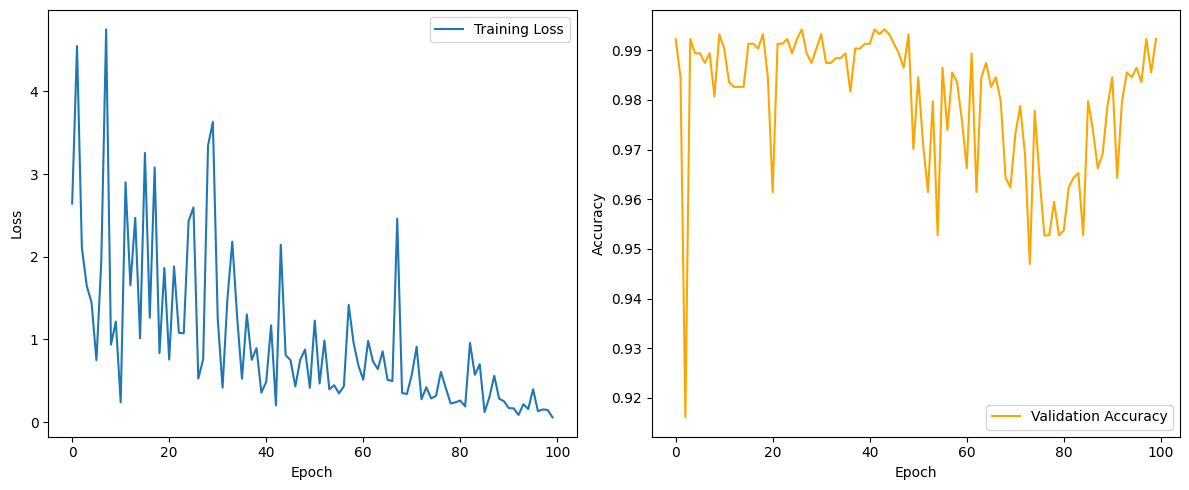

In [14]:
import matplotlib.pyplot as plt

losses = []
val_accs = []
best_val_f1 = 0

for epoch in range(1, 101):
    train_loss = train()
    val_acc = validate()
    
    losses.append(train_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_f1:
        best_val_f1 = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        
    print(f'Epoch {epoch:03d}, Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()



Sample Predictions:
Edge 1: Predicted Support | Actual Support
Edge 2: Predicted Support | Actual Support
Edge 3: Predicted Support | Actual Support
Edge 4: Predicted Support | Actual Support
Edge 5: Predicted Support | Actual Support
Edge 6: Predicted Support | Actual Support
Edge 7: Predicted Support | Actual Support
Edge 8: Predicted Support | Actual Support
Edge 9: Predicted Support | Actual Support
Edge 10: Predicted Support | Actual Support


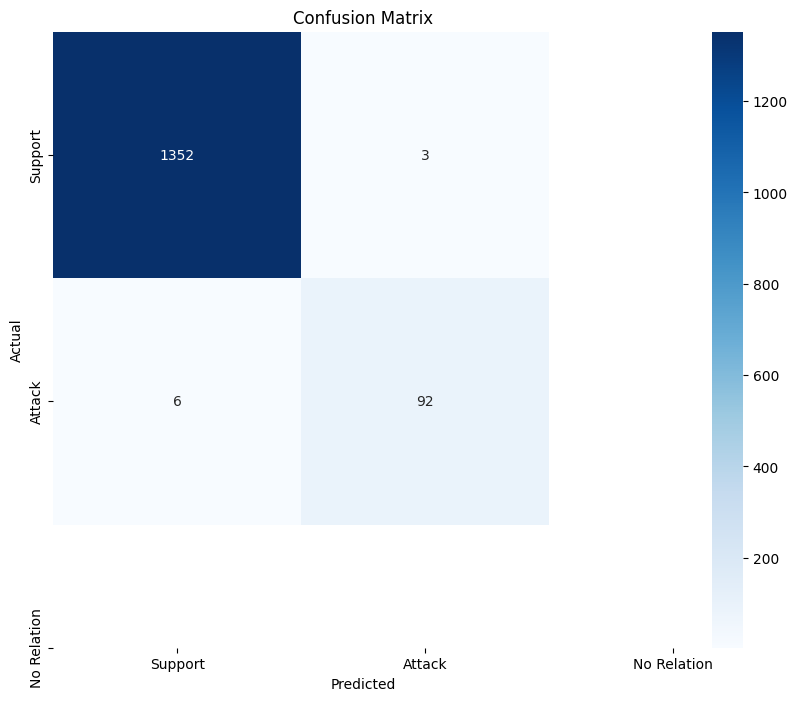


Classification Report:
              precision    recall  f1-score   support

     Support       1.00      1.00      1.00      1355
      Attack       0.97      0.94      0.95        98
 No Relation       0.00      0.00      0.00         0

    accuracy                           0.99      1453
   macro avg       0.65      0.65      0.65      1453
weighted avg       0.99      0.99      0.99      1453


Weighted Average Metrics:
Precision: 0.9937
Recall: 0.9938
F1 Score: 0.9938


In [15]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from torch_geometric.nn import RGCNConv


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()


def load_test_data(output_dir="graph_data"):
    pt_files = list(Path(output_dir).glob("*.pt"))
    test_data = []
    
    for pt_file in pt_files:
        try:
            data = torch.load(pt_file, weights_only=False)
            test_data.append(data)
        except Exception as e:
            print(f"Error loading {pt_file.name}: {str(e)}")
    
    return test_data


test_data = load_test_data()

# 3. Prediction and evaluation
all_preds = []
all_true = []

for data in test_data:
    data = data.to(device)
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)
        preds = out.argmax(dim=1).cpu().numpy()
        
    # Get true labels (assuming edge_type contains labels)
    true_labels = data.edge_type.cpu().numpy()
    
    all_preds.extend(preds)
    all_true.extend(true_labels)

# 4. Human-readable predictions
label_map = {
    0: 'Support',
    1: 'Attack',
    2: 'No Relation'
}

print("\nSample Predictions:")
for i in range(min(10, len(all_preds))):
    print(f"Edge {i+1}: Predicted {label_map[all_preds[i]]} | Actual {label_map[all_true[i]]}")

# 5. Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

labels = [0, 1, 2]  
# 6. Metrics
print("\nClassification Report:")
print(classification_report(all_true, all_preds, labels=labels, target_names=label_map.values(), zero_division=0))

# 7. Calculate final metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='weighted', zero_division=0)
print(f"\nWeighted Average Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
